In [6]:
import pandas as pd
import numpy as np
import sklearn.model_selection as skm
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [2]:
from sklearn.datasets import fetch_openml

df = fetch_openml(data_id = 31)
y = df.target
X = df.data

print(X.dtypes)

checking_status           category
duration                     int64
credit_history            category
purpose                   category
credit_amount                int64
savings_status            category
employment                category
installment_commitment       int64
personal_status           category
other_parties             category
residence_since              int64
property_magnitude        category
age                          int64
other_payment_plans       category
housing                   category
existing_credits             int64
job                       category
num_dependents               int64
own_telephone             category
foreign_worker            category
dtype: object


In [3]:
X.isnull().sum()

checking_status           0
duration                  0
credit_history            0
purpose                   0
credit_amount             0
savings_status            0
employment                0
installment_commitment    0
personal_status           0
other_parties             0
residence_since           0
property_magnitude        0
age                       0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
dtype: int64

In [4]:
y.isnull().sum()

0

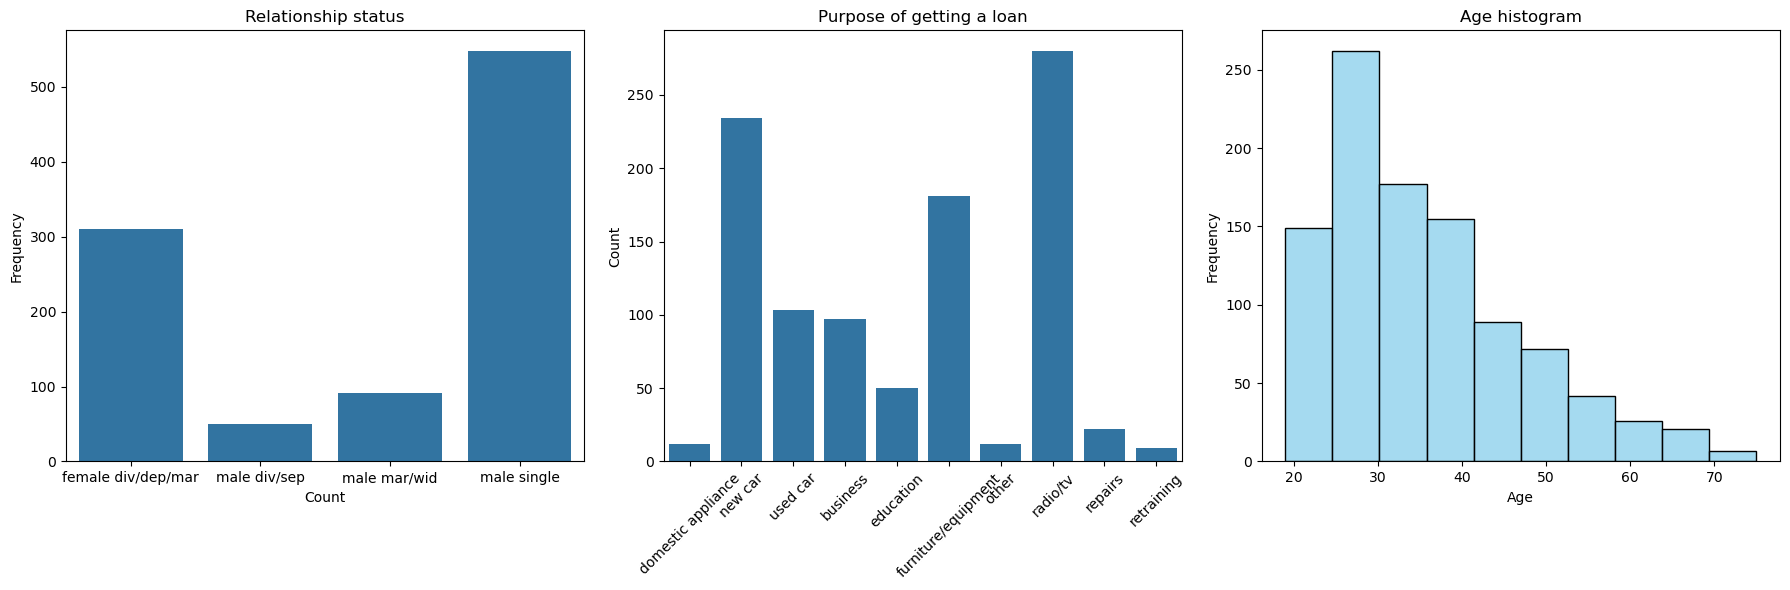

In [7]:
#Histogramy do wstępnej analizy danych
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 


sns.countplot(x=X['personal_status'], ax=axes[0])
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Relationship status")


sns.countplot(x=X['purpose'], ax=axes[1])
axes[1].set_xlabel("")
axes[1].set_ylabel("Count")
axes[1].set_title("Purpose of getting a loan")
axes[1].tick_params(axis='x', rotation=45)


sns.histplot(X['age'], bins=10, kde=False, ax=axes[2], color="skyblue")
axes[2].set_xlabel("Age")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Age histogram")


plt.tight_layout()
plt.savefig("credit_analysis.png", dpi=300)  
plt.show()


In [10]:
# We perform data transformation (split categorical variables to create corresponding columns, 
# and transform numeric variables by standardizing them)
# Additionally, we convert the vector so that good is represented by 1 and bad by 0
# and numeric variables are standardized.

numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = X.select_dtypes(include=['category']).columns

X_categorical = pd.get_dummies(X[categorical_columns], drop_first=True)
scaler = StandardScaler()
X_numeric = pd.DataFrame(scaler.fit_transform(X[numeric_columns]), columns=numeric_columns)

X_enc = pd.concat([X_numeric, X_categorical], axis=1)

labelencoder = LabelEncoder()
y_enc = labelencoder.fit_transform(y)

X_enc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 48 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   duration                                       1000 non-null   float64
 1   credit_amount                                  1000 non-null   float64
 2   installment_commitment                         1000 non-null   float64
 3   residence_since                                1000 non-null   float64
 4   age                                            1000 non-null   float64
 5   existing_credits                               1000 non-null   float64
 6   num_dependents                                 1000 non-null   float64
 7   checking_status_<0                             1000 non-null   bool   
 8   checking_status_>=200                          1000 non-null   bool   
 9   checking_status_no checking                    1000 n

In [ ]:
#Train/test set
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size = 0.25 ,random_state=320768)

<h4> Aim of this experiment is to check the importance of penalty functions in Logistic Regression model

In [14]:
#First we begin with a model with no penalty
glm_np = LogisticRegression(penalty = None, max_iter = 100000)
glm_np.fit(X_train, y_train)

LogisticRegression(max_iter=100000, penalty=None)

In [15]:
#Here using 5 time crossvalidation and a grid search we look for a best, in respect to auc, model with l1 regularization (lasso)
kfold = skm.KFold(5,
                  random_state=320768,
                  shuffle=True)

glm = LogisticRegression(penalty = 'l1', solver = 'liblinear').fit(X_train, y_train)

grid = skm.GridSearchCV(glm,
                        {'C':[0.001, 0.01, 0.1, 1, 5, 10, 100]}, 
                         refit=True,
                         cv=kfold,
                         scoring='roc_auc')

grid.fit(X_train, y_train)
glm_l1 =  grid.best_estimator_
grid.best_params_

{'C': 1}

In [16]:
#Same as previous one but now with l2 regularization (ridge)
kfold = skm.KFold(5,
                  random_state=320768,
                  shuffle=True)

glm_l2 = LogisticRegression(penalty = 'l2', solver = 'liblinear').fit(X_train, y_train)

grid = skm.GridSearchCV(glm_l2,
                        {'C':[0.001, 0.01, 0.1, 1, 5, 10, 100]}, 
                         refit=True,
                         cv=kfold,
                         scoring='roc_auc')

grid.fit(X_train, y_train)
glm_l2 =  grid.best_estimator_
grid.best_params_

{'C': 0.1}

In [17]:
#Last model rules are the same as for the previous ones but this time with Elastic-Net penalty
kfold = skm.KFold(5, random_state=320768, shuffle=True)

glm_elasticnet = LogisticRegression(
    penalty='elasticnet', 
    solver='saga',
    max_iter=100000  
)

grid = skm.GridSearchCV(
    glm_elasticnet,
    param_grid={
        'C': [0.01, 1,10, 1000],
        'l1_ratio': [0.3, 0.5, 0.9]  
    },
    refit=True,
    cv=kfold,
    scoring='roc_auc'
)

grid.fit(X_train, y_train)

glm_en = grid.best_estimator_
grid.best_params_


{'C': 1, 'l1_ratio': 0.5}

In [18]:
#We look for basic metrics on test and train set.
from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve, accuracy_score
y_pred_np =  glm_np.predict(X_test)
y_pred_l1 = glm_l1.predict(X_test)
y_pred_l2 = glm_l2.predict(X_test)
y_pred_en = glm_en.predict(X_test)

print('---Metrics on the test set---')
print("LOGISTIC REGRESSION MODEL WITHOUT PENALTY")
print("---------------------------")
print("precision", np.round(precision_score(y_test, y_pred_np), 3))
print("recall:", np.round(recall_score(y_test, y_pred_np), 3))
print("accuracy:", np.round(accuracy_score(y_test, y_pred_np), 3))
print("AUC", np.round(roc_auc_score(y_test, glm_np.predict_proba(X_test)[:, 1]), 3))
print("---------------------------")
print("---------------------------")
print("LOGISTIC REGRESSION MODEL WITH L1 PENALTY")
print("---------------------------")
print("precision", np.round(precision_score(y_test, y_pred_l1), 3))
print("recall:", np.round(recall_score(y_test, y_pred_l1), 3))
print("accuracy:", np.round(accuracy_score(y_test, y_pred_l1), 3))
print("AUC", np.round(roc_auc_score(y_test, glm_l1.predict_proba(X_test)[:, 1]), 3))
print("---------------------------")
print("---------------------------")
print("LOGISTIC REGRESSION MODEL WITH L2 PENALTY")
print("---------------------------")
print("precision", np.round(precision_score(y_test, y_pred_l2), 3))
print("recall:", np.round(recall_score(y_test, y_pred_l2), 3))
print("accuracy:", np.round(accuracy_score(y_test, y_pred_l2), 3))
print("AUC", np.round(roc_auc_score(y_test, glm_l2.predict_proba(X_test)[:, 1]), 3))
print("---------------------------")
print("---------------------------")
print("LOGISTIC REGRESSION MODEL WITH ELASTICNET")
print("---------------------------")
print("precision", np.round(precision_score(y_test, y_pred_en), 3))
print("recall:", np.round(recall_score(y_test, y_pred_en), 3))
print("accuracy:", np.round(accuracy_score(y_test, y_pred_en), 3))
print("AUC", np.round(roc_auc_score(y_test, glm_en.predict_proba(X_test)[:, 1]), 3))


---Metrics on the test set---
LOGISTIC REGRESSION MODEL WITHOUT PENALTY
---------------------------
precision 0.825
recall: 0.839
accuracy: 0.756
AUC 0.787
---------------------------
---------------------------
LOGISTIC REGRESSION MODEL WITH L1 PENALTY
---------------------------
precision 0.813
recall: 0.844
accuracy: 0.748
AUC 0.794
---------------------------
---------------------------
LOGISTIC REGRESSION MODEL WITH L2 PENALTY
---------------------------
precision 0.79
recall: 0.878
accuracy: 0.744
AUC 0.793
---------------------------
---------------------------
LOGISTIC REGRESSION MODEL WITH ELASTICNET
---------------------------
precision 0.817
recall: 0.844
accuracy: 0.752
AUC 0.792


In [19]:
y_pred_np =  glm_np.predict(X_train)
y_pred_l1 = glm_l1.predict(X_train)
y_pred_l2 = glm_l2.predict(X_train)
y_pred_en = glm_en.predict(X_train)

print('---Metrics on the training set---')
print("---------------------------")
print("LOGISTIC REGRESSION MODEL WITHOUT PENALTY")
print("precision", np.round(precision_score(y_train, y_pred_np), 3))
print("recall:", np.round(recall_score(y_train, y_pred_np), 3))
print("accuracy:", np.round(accuracy_score(y_train, y_pred_np), 3))
print("AUC", np.round(roc_auc_score(y_train, glm_np.predict_proba(X_train)[:, 1]), 3))
print("---------------------------")
print("LOGISTIC REGRESSION MODEL WITH L1 PENALTY")
print("precision", np.round(precision_score(y_train, y_pred_l1), 3))
print("recall:", np.round(recall_score(y_train, y_pred_l1), 3))
print("accuracy:", np.round(accuracy_score(y_train, y_pred_l1), 3))
print("AUC", np.round(roc_auc_score(y_train, glm_l1.predict_proba(X_train)[:, 1]), 3))
print("---------------------------")
print("LOGISTIC REGRESSION MODEL WITH L2 PENALTY")
print("precision", np.round(precision_score(y_train, y_pred_l2), 3))
print("recall:", np.round(recall_score(y_train, y_pred_l2), 3))
print("accuracy:", np.round(accuracy_score(y_train, y_pred_l2), 3))
print("AUC", np.round(roc_auc_score(y_train, glm_l2.predict_proba(X_train)[:, 1]), 3))
print("---------------------------")
print("LOGISTIC REGRESSION MODEL WITH ELASTICNET")
print("precision", np.round(precision_score(y_train, y_pred_en), 3))
print("recall:", np.round(recall_score(y_train, y_pred_en), 3))
print("accuracy:", np.round(accuracy_score(y_train, y_pred_en), 3))
print("AUC", np.round(roc_auc_score(y_train, glm_en.predict_proba(X_train)[:, 1]), 3))


---Metrics on the training set---
---------------------------
LOGISTIC REGRESSION MODEL WITHOUT PENALTY
precision 0.815
recall: 0.9
accuracy: 0.789
AUC 0.837
---------------------------
LOGISTIC REGRESSION MODEL WITH L1 PENALTY
precision 0.811
recall: 0.898
accuracy: 0.784
AUC 0.834
---------------------------
LOGISTIC REGRESSION MODEL WITH L2 PENALTY
precision 0.799
recall: 0.919
accuracy: 0.784
AUC 0.827
---------------------------
LOGISTIC REGRESSION MODEL WITH ELASTICNET
precision 0.811
recall: 0.9
accuracy: 0.785
AUC 0.836


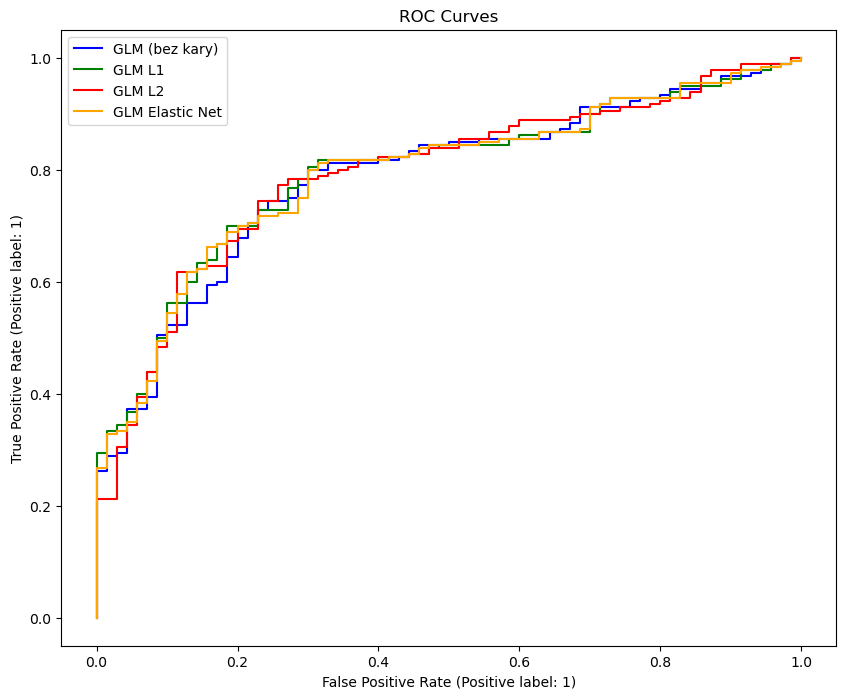

In [20]:
#Plotting ROC curves for test set

fpr_np, tpr_np, _ = roc_curve(y_test, glm_np.predict_proba(X_test)[:, 1])
fpr_l1, tpr_l1, _ = roc_curve(y_test, glm_l1.predict_proba(X_test)[:, 1])
fpr_l2, tpr_l2, _ = roc_curve(y_test, glm_l2.predict_proba(X_test)[:, 1])
fpr_grid, tpr_grid, _ = roc_curve(y_test, glm_en.predict_proba(X_test)[:, 1])


plt.figure(figsize=(10, 8))
plt.plot(fpr_np, tpr_np, label="GLM (bez kary)", color='blue')
plt.plot(fpr_l1, tpr_l1, label="GLM L1", color='green')
plt.plot(fpr_l2, tpr_l2, label="GLM L2", color='red')
plt.plot(fpr_grid, tpr_grid, label="GLM Elastic Net", color='orange')


plt.xlabel("False Positive Rate (Positive label: 1)")
plt.ylabel("True Positive Rate (Positive label: 1)")
plt.title("ROC Curves")
plt.legend()
plt.show()

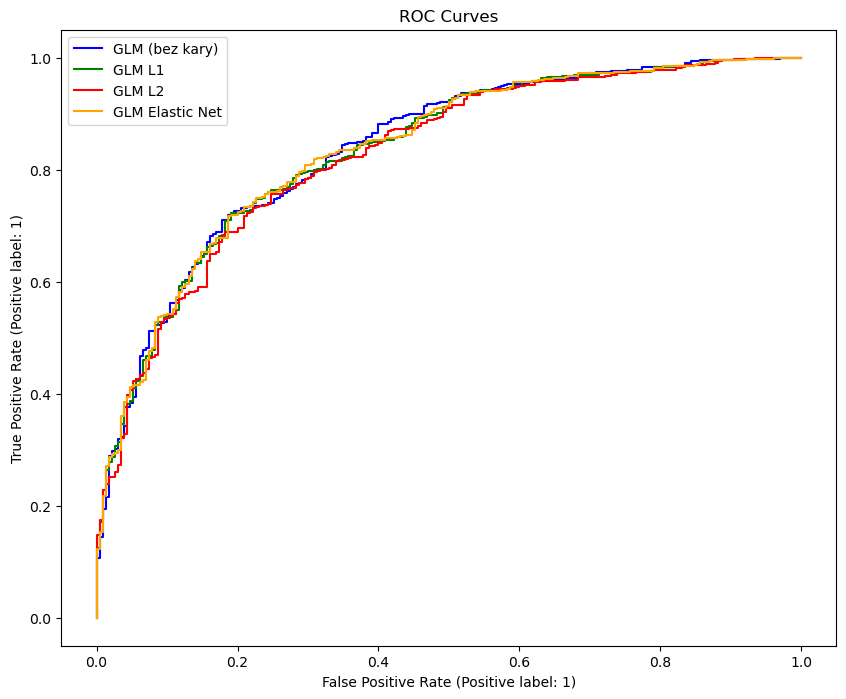

In [21]:
#Plotting ROC curves for train set

fpr_np, tpr_np, _ = roc_curve(y_train, glm_np.predict_proba(X_train)[:, 1])
fpr_l1, tpr_l1, _ = roc_curve(y_train, glm_l1.predict_proba(X_train)[:, 1])
fpr_l2, tpr_l2, _ = roc_curve(y_train, glm_l2.predict_proba(X_train)[:, 1])
fpr_grid, tpr_grid, _ = roc_curve(y_train, glm_en.predict_proba(X_train)[:, 1])


plt.figure(figsize=(10, 8))
plt.plot(fpr_np, tpr_np, label="GLM (bez kary)", color='blue')
plt.plot(fpr_l1, tpr_l1, label="GLM L1", color='green')
plt.plot(fpr_l2, tpr_l2, label="GLM L2", color='red')
plt.plot(fpr_grid, tpr_grid, label="GLM Elastic Net", color='orange')


plt.xlabel("False Positive Rate (Positive label: 1)")
plt.ylabel("True Positive Rate (Positive label: 1)")
plt.title("ROC Curves")
plt.legend()
plt.show()

In [119]:
#Generujemy tabelke wspolczynnikow. (Jaki wspołczynnik przy danej zmiennej w każdym z modeli)

zmienne = X_enc.columns.tolist()
coefs_np = glm_np.coef_[0]
coefs_l1 = glm_l1.coef_[0]
coefs_l2 = glm_l2.coef_[0]
coefs_grid = glm_en.coef_[0]


coefficients_df = pd.DataFrame({
    "GLM (No Penalty)": coefs_np,
    "GLM L1 Regularization": coefs_l1,
    "GLM L2 Regularization": coefs_l2,
    "Grid Search Model": coefs_grid
}, index=zmienne)


print(coefficients_df)

                                               GLM (No Penalty)  \
duration                                              -0.234781   
credit_amount                                         -0.440615   
installment_commitment                                -0.302486   
residence_since                                       -0.022222   
age                                                    0.152941   
existing_credits                                      -0.077849   
num_dependents                                        -0.080843   
checking_status_<0                                    -0.454550   
checking_status_>=200                                  0.470725   
checking_status_no checking                            1.342603   
credit_history_critical/other existing credit          1.774122   
credit_history_delayed previously                      0.979131   
credit_history_existing paid                           1.113586   
credit_history_no credits/all paid                     0.53038

In [121]:
#Czesc 2

In [123]:
#Wybieranie zmiennych które potraktujemy jako nieważne, na przykładzie modelu stosującego l1 regularyzacje

X_train_reduced = X_train[X_train.columns[(np.absolute(glm_l1.coef_)>0.5)[0]]]
X_test_reduced = X_test[X_test.columns[(np.absolute(glm_l1.coef_)>0.5)[0]]]


In [125]:
from sklearn.svm import SVC

svm_linear = SVC(C = 0.1, kernel = 'linear').fit(X_train_reduced,y_train)

kfold = skm.KFold(5,
                  random_state=0,
                  shuffle=True)



grid = skm.GridSearchCV(svm_linear,
                        {'C':[0.001, 0.01, 0.1, 1, 5, 10, 100]}, 
                         refit=True,
                         cv=kfold,
                         scoring='roc_auc')
grid.fit(X_train_reduced, y_train)

best_svm = grid.best_estimator_
grid.best_params_

{'C': 0.1}

In [127]:
#Znalezienie miar na zbiorze testowym
y_pred_test = best_svm.predict(X_test_reduced)
ds = svm_linear.decision_function(X_test_reduced)

print('---Metryki na zbiorze testowym---')
print("---------------------------")
print("precision", np.round(precision_score(y_test, y_pred_test), 3))
print("recall:", np.round(recall_score(y_test, y_pred_test), 3))
print("accuracy:", np.round(accuracy_score(y_test, y_pred_test), 3))
print("AUC", np.round(roc_auc_score(y_test, ds), 3))

---Metryki na zbiorze testowym---
---------------------------
precision 0.721
recall: 0.989
accuracy: 0.716
AUC 0.69


In [129]:
#Znalezienie miar na zbiorze treningowym
y_pred_train = best_svm.predict(X_train_reduced)
ds = svm_linear.decision_function(X_train_reduced)

print('---Metryki na zbiorze treningowym---')
print("---------------------------")
print("precision", np.round(precision_score(y_train, y_pred_train), 3))
print("recall:", np.round(recall_score(y_train, y_pred_train), 3))
print("accuracy:", np.round(accuracy_score(y_train, y_pred_train), 3))
print("AUC", np.round(roc_auc_score(y_train, ds), 3))

---Metryki na zbiorze treningowym---
---------------------------
precision 0.705
recall: 0.998
accuracy: 0.709
AUC 0.76


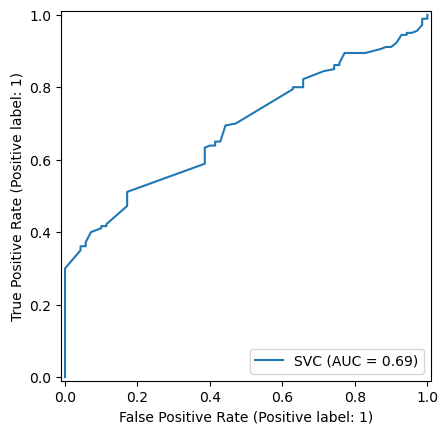

In [131]:
#Krzywa ROC na zbiorze testowym
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(best_svm, X_test_reduced, y_test)

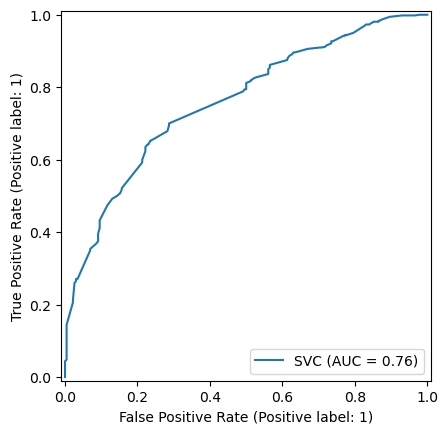

In [133]:
#Krzywa ROC na zbiorze treningowym
RocCurveDisplay.from_estimator(best_svm, X_train_reduced, y_train)